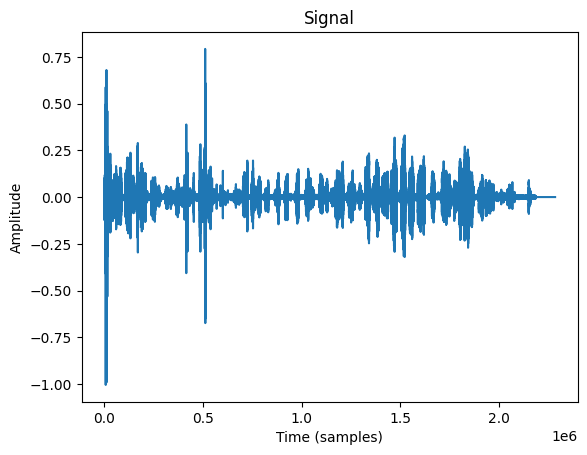

In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load('-sTnP0BeOS4_30.wav')

plt.plot(y);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

In [5]:
import pandas as pd
import numpy as np

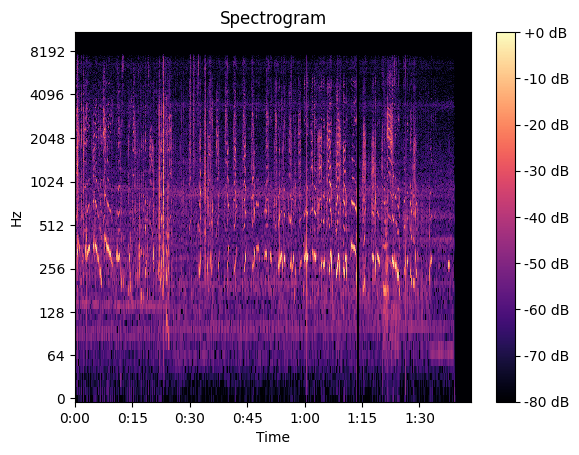

In [6]:
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

In [7]:
# 관련 라이브러리 가져오기
import matplotlib.pyplot as plt

import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [8]:
# glob: 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
base_dir = './audioset-processing-master/output/meow'
train_folder = glob(base_dir)

train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

In [9]:

# ti = 0
# for i in range(len(train_path)):
#     #librosa.get_duration(filename='train_path[i]')
#     ti+= librosa.get_duration(filename=train_path[i])
#     if i%100==0:
#         print(i)
# print(ti)


In [10]:
49102.238500000014+16202.77149999999

65305.01

./audioset-processing-master/output/meow\-46xqouqMxA_6.wav


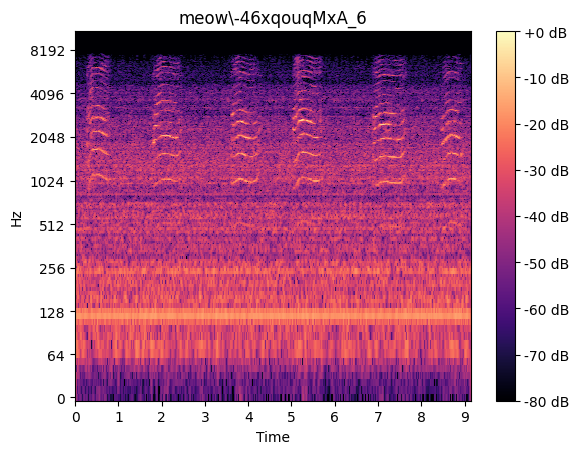

In [31]:
vidno=4
y, sr = librosa.load(train_path[vidno])
print(train_path[vidno])
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec[:,:600], sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title(train_path[vidno].split('/')[-1].split('.')[0]);

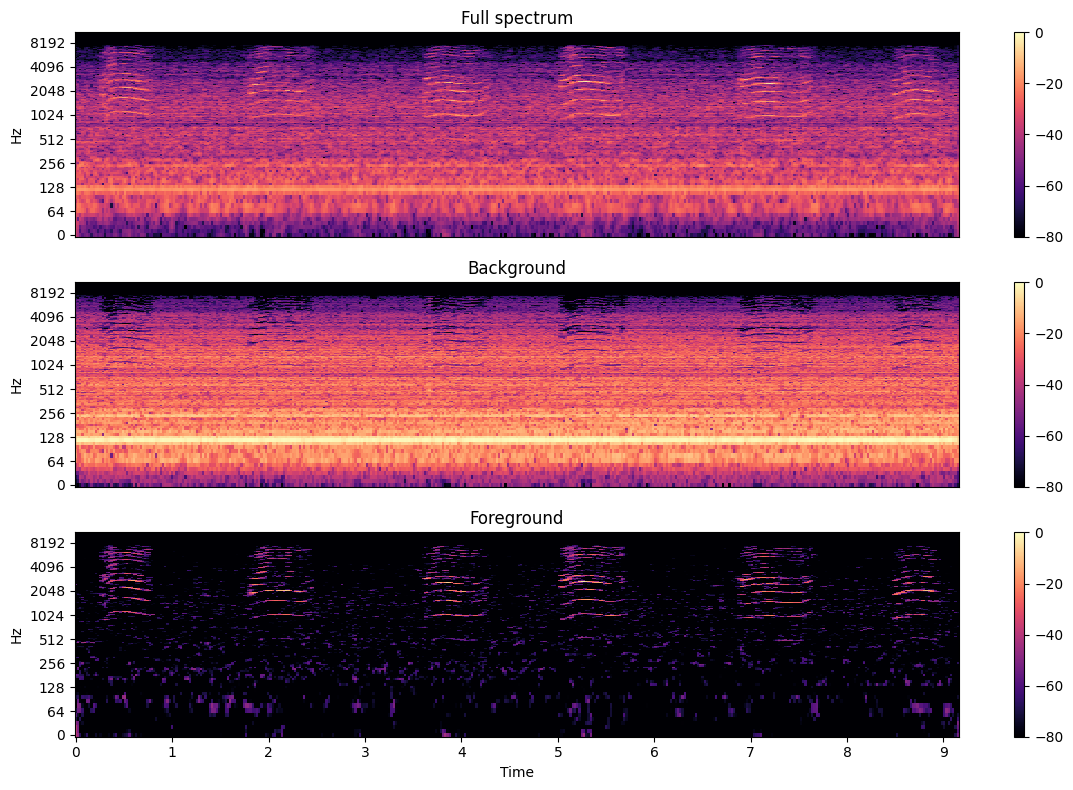

In [32]:

S_full, phase = librosa.magphase(librosa.stft(y))



# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components
S_foreground = mask_v * S_full
S_background = mask_i * S_full
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [33]:
def ctft_to_peaks(carr : np.ndarray, threshold = 1, max_peak_num = 10):
    rising = np.zeros(shape=(max_peak_num, carr.shape[1]))
    falling = np.zeros(shape=(max_peak_num , carr.shape[1]))
    diff=np.diff(np.sign(carr.T-threshold), axis = 1)

    for arr, num in [(rising, 2), (falling, -2)]:
        a,b = np.where(diff==num)
        for i in range(diff.shape[0]):
            temp=b[a==i]
            minlen = min(max_peak_num, len(temp))
            arr[:minlen,i]=temp[:minlen]

    return (rising, falling)

In [34]:
from scipy.signal import convolve2d
S_smoothed = convolve2d(S_foreground, np.ones(3).reshape((1,-1))/5)

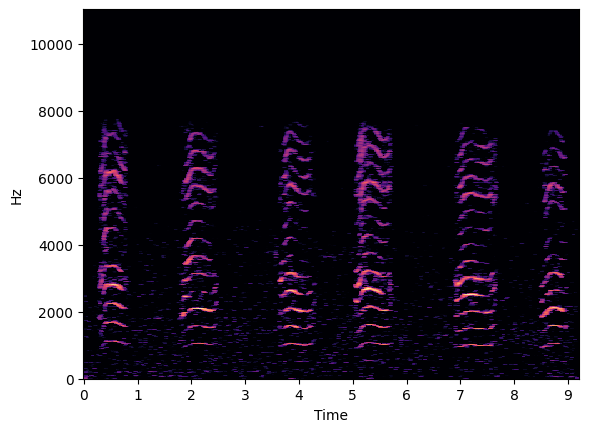

In [35]:
librosa.display.specshow(librosa.amplitude_to_db(S_smoothed, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)

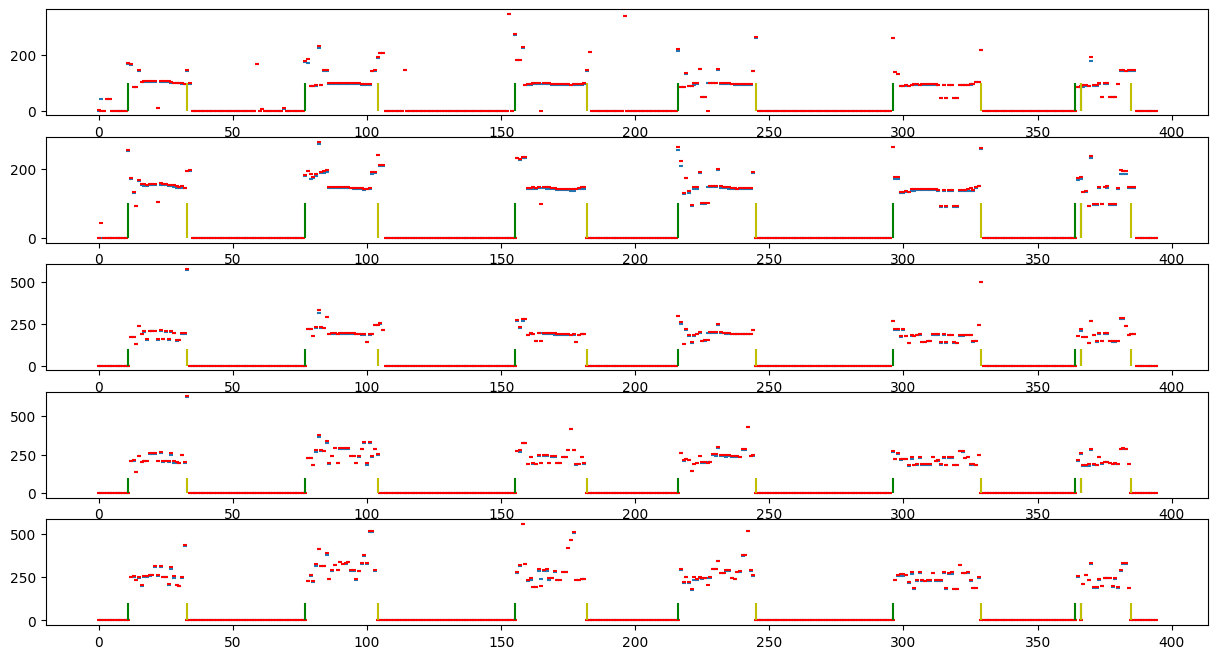

In [36]:
rising, falling = ctft_to_peaks(S_foreground, threshold=0.1, max_peak_num=5)

x=np.arange(0, rising.shape[1],1/1).astype(int)
plt.figure(figsize=(15,8))

#의미있는 부분만 잘라내기
cnt_mat = (rising > 1e-5).sum(axis=0)
thres = 5 - 0.5
cutpoint_rising = np.where(np.diff(np.sign(cnt_mat-thres))==2)[0]
cutpoint_falling = np.where(np.diff(np.sign(cnt_mat-thres))==-2)[0]+1
if(cnt_mat[0] > thres):
    cutpoint_rising = np.insert(0,0,cutpoint_rising)

for num in range(5):
    rising_2 = rising[num,:]
    falling_2 = falling[num,:]
    plt.subplot(5,1,num+1)
    plt.scatter(x[:], rising_2[:], s=10, marker='_')
    plt.scatter(x[:], falling_2[:], s=10, marker='_', c='r')
    plt.vlines(x=cutpoint_rising, ymin=0, ymax= 100,color='g')
    plt.vlines(x=cutpoint_falling, ymin=0, ymax= 100,color='y')

In [37]:
# for num in range(len(cutpoint_rising)):
#     print(librosa.frames_to_time(cutpoint_rising[num],sr=sr), librosa.frames_to_time(cutpoint_falling[num],sr=sr))
# print(len(cutpoint_rising))

In [38]:
for i in range(len(cutpoint_rising)):
    print(cutpoint_rising[i], cutpoint_falling[i])
    print(("ffmpeg -y -ss " + str(librosa.frames_to_time(cutpoint_rising[i],sr=sr)) + " -t " + str(librosa.frames_to_time(cutpoint_falling[i],sr=sr)-librosa.frames_to_time(cutpoint_rising[i],sr=sr)) + " -i " +str(train_path[vidno])+" ./test/"+str(train_path[vidno].split('/')[-1].split(".")[0])+'_'+str(i)+".wav"))
    os.system(("ffmpeg -y -ss " + str(librosa.frames_to_time(cutpoint_rising[i],sr=sr)) + " -t " + str(librosa.frames_to_time(cutpoint_falling[i],sr=sr)-librosa.frames_to_time(cutpoint_rising[i],sr=sr)) + " -i " +str(train_path[vidno])+" ./test/"+str(train_path[vidno].split('/')[-1].split(".")[0])+'_'+str(i)+".wav"))

11 33
ffmpeg -y -ss 0.25541950113378686 -t 0.5108390022675737 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_0.wav
77 104
ffmpeg -y -ss 1.787936507936508 -t 0.6269387755102043 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_1.wav
155 182
ffmpeg -y -ss 3.599092970521542 -t 0.6269387755102045 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_2.wav
216 245
ffmpeg -y -ss 5.015510204081632 -t 0.6733786848072567 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_3.wav
296 329
ffmpeg -y -ss 6.873106575963718 -t 0.7662585034013611 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_4.wav
364 366
ffmpeg -y -ss 8.452063492063493 -t 0.04643990929705133 -i ./audioset-processing-master/output/meow\-46xqouqMxA_6.wav ./test/meow\-46xqouqMxA_6_5.wav
366 385
ffmpeg -y -ss 8.498503401360544 -t 0.4411791383219956 -i